##Metode Graph Convolutional Network
##Embedding : TFIDF with 100 max features
##Arsitektur:
- Using Cosine Similarity : 0,5
- Pembagian Data Train, Validation, Testing : 80:10:10 with stratify
- GCN : 2 Layer : Activasi ReLu : Output Softmax
- GAT : 2 Layer : Activasi ELu : Output Softmax

##Parameter Training
- Optimizer : Adam
- Learning Rate : 0,01
- Epoch : 100

In [ ]:
# Menghubungkan dengan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Library
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install gensim
!pip install fasttext-wheel

# Import libraries
import pandas as pd
import re
import numpy as np
import torch
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 15.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
# Fungsi pembersihan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'http\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\r?\n|\r', '', text)
    return text

# Fungsi untuk memproses dataset dengan TF-IDF
def load_and_process_dataset(file_path, tfidf_vectorizer):
    try:
        data = pd.read_csv(file_path)
        print(f"Dataset {file_path} berhasil dimuat!")
    except FileNotFoundError:
        print(f"Gagal memuat dataset {file_path}. Periksa path file atau pastikan file ada di Google Drive.")
        return None

    # Pembersihan teks
    print("Memproses teks...")
    data['text'] = data['text'].apply(clean_text)

    # Representasi teks dengan TF-IDF
    print("Menghitung TF-IDF...")
    tfidf_features = tfidf_vectorizer.fit_transform(data['text']).toarray()
    data['tfidf_embedding'] = tfidf_features.tolist()

    # Konversi label menjadi numerik
    label_encoder = LabelEncoder()
    data['class_label_numerik'] = label_encoder.fit_transform(data['class_label'])

    # Menampilkan distribusi kelas
    print("\nDistribusi kelas:")
    class_distribution = data['class_label'].value_counts().reset_index()
    class_distribution.columns = ['Class Label', 'Count']
    display(class_distribution)

    return data

In [ ]:
def build_graph(data, similarity_threshold=0.5, embedding_col='tfidf_embedding'):
    G = nx.Graph()

    # Tambahkan node ke graf
    for idx, row in data.iterrows():
        G.add_node(idx,
                   features=row[embedding_col],
                   label=row['class_label_numerik'])

    # Hitung cosine similarity antar-node
    embeddings = np.array(data[embedding_col].tolist())
    similarity_matrix = cosine_similarity(embeddings)

    # Tambahkan edge berdasarkan kesamaan
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                continue
            if similarity_matrix[i, j] >= similarity_threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G

# Fungsi untuk mengonversi graf ke format PyTorch Geometric
def convert_to_pyg_data(graph):
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    node_features = torch.tensor([graph.nodes[node]['features'] for node in graph.nodes], dtype=torch.float)
    labels = torch.tensor([graph.nodes[node]['label'] for node in graph.nodes], dtype=torch.long)

    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data

In [ ]:
# Fungsi untuk visualisasi graph dengan lebih detail
def visualize_graph_detailed(graph, node_labels=None, title="Graph Visualization", figsize=(15, 10)):
    """
    Visualisasi graph dengan fitur yang lebih detail termasuk warna node berdasarkan label,
    ukuran node berdasarkan degree, dan ketebalan edge berdasarkan weight
    """
    plt.figure(figsize=figsize)

    # Gunakan spring layout untuk tata letak graph
    pos = nx.spring_layout(graph, k=1, iterations=50)

    # Hitung degree untuk setiap node
    degrees = dict(graph.degree())

    # Normalisasi ukuran node berdasarkan degree
    node_sizes = [((degrees[node] + 1) * 100) for node in graph.nodes()]

    # Warna node berdasarkan label jika tersedia
    if node_labels is not None:
        unique_labels = list(set(node_labels))
        color_map = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_labels)))
        node_colors = [color_map[unique_labels.index(node_labels[node])] for node in graph.nodes()]
    else:
        node_colors = 'lightblue'

    # Gambar nodes
    nodes = nx.draw_networkx_nodes(graph, pos,
                                 node_size=node_sizes,
                                 node_color=node_colors,
                                 alpha=0.7)
    nodes.set_edgecolor('black')

    # Gambar edges dengan ketebalan berdasarkan weight
    edge_weights = [graph[u][v]['weight'] * 2 for u, v in graph.edges()]
    nx.draw_networkx_edges(graph, pos,
                          width=edge_weights,
                          alpha=0.5,
                          edge_color='gray')

    # Tambahkan label untuk beberapa node dengan degree tertinggi
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = {node: f"Node {node}" for node, _ in top_nodes}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)

    # Tambahkan legenda untuk label kelas jika tersedia
    if node_labels is not None:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=color_map[i], label=f'Class {label}',
                                    markersize=10)
                         for i, label in enumerate(unique_labels)]
        plt.legend(handles=legend_elements, loc='upper right', title='Classes')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_graph_metrics(graph):
    """
    Visualisasi berbagai metrik graph dalam bentuk subplot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Graph Metrics Visualization', fontsize=16)

    # 1. Degree Distribution
    degrees = [d for n, d in graph.degree()]
    axes[0, 0].hist(degrees, bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Degree Distribution')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')

    # 2. Edge Weight Distribution
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    axes[0, 1].hist(weights, bins=30, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Edge Weight Distribution')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Node Clustering Coefficient Distribution
    clustering_coeffs = list(nx.clustering(graph).values())
    axes[1, 0].hist(clustering_coeffs, bins=30, color='salmon', edgecolor='black')
    axes[1, 0].set_title('Clustering Coefficient Distribution')
    axes[1, 0].set_xlabel('Clustering Coefficient')
    axes[1, 0].set_ylabel('Frequency')

    # 4. Graph Component Size Distribution
    components = list(nx.connected_components(graph))
    component_sizes = [len(c) for c in components]
    axes[1, 1].hist(component_sizes, bins=30, color='purple', alpha=0.6, edgecolor='black')
    axes[1, 1].set_title('Component Size Distribution')
    axes[1, 1].set_xlabel('Component Size')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print additional metrics
    print("\nGraph Metrics Summary:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
    print(f"Average clustering coefficient: {sum(clustering_coeffs)/len(clustering_coeffs):.3f}")
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {max(component_sizes)}")
    print(f"Graph density: {nx.density(graph):.3f}")

# Contoh penggunaan fungsi visualisasi setelah membuat graph
def visualize_complete_graph(data, graph):
    """
    Menampilkan semua visualisasi graph untuk analisis komprehensif
    """
    print("Visualizing graph structure...")
    visualize_graph_detailed(graph,
                           node_labels=data['class_label_numerik'].tolist(),
                           title="TF IDF Graph Structure")

    print("\nVisualizing graph metrics...")
    visualize_graph_metrics(graph)

    # Tambahan: Visualisasi heatmap similarity matrix
    print("\nVisualizing similarity matrix...")
    plt.figure(figsize=(10, 8))
    embeddings = np.array(data['tfidf_embedding'].tolist())
    similarity_matrix = cosine_similarity(embeddings)

    plt.imshow(similarity_matrix, cmap='YlOrRd')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Node Similarity Matrix')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.show()

In [ ]:
# Fungsi untuk training dan evaluasi
def train_and_evaluate(model, optimizer, data, num_epochs=100):
    criterion = torch.nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    def train(model, optimizer, data):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item(), out

    def evaluate(model, data, mask):
        model.eval()
        with torch.no_grad():
            out = model(data)
            loss = criterion(out[mask], data.y[mask])
            pred = out.argmax(dim=1)
            correct = pred[mask].eq(data.y[mask]).sum().item()
            acc = correct / mask.sum().item()
        return loss, acc, pred

    # Training dan evaluasi per epoch
    for epoch in range(num_epochs):
        train_loss, train_out = train(model, optimizer, data)
        train_acc = (train_out[data.train_mask].argmax(dim=1).eq(data.y[data.train_mask]).sum().item()
                     / data.train_mask.sum().item())
        val_loss, val_acc, _ = evaluate(model, data, data.val_mask)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Visualisasi Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # Visualisasi Akurasi
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Evaluasi pada data testing
    test_loss, test_accuracy, pred = evaluate(model, data, data.test_mask)

    y_test = data.y[data.test_mask].numpy()
    pred_test = pred[data.test_mask].numpy()

    # Hitung metrik evaluasi
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    print("\nEvaluasi Testing:")
    print(f"Accuracy : {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, pred_test)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=set(y_test))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # Laporan Klasifikasi
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, pred_test))

In [ ]:
# Model GCN
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


Processing dataset: Banjir
Dataset /content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/banjir_id_cleaned.csv berhasil dimuat!
Memproses teks...
Menghitung TF-IDF...

Distribusi kelas:


Class Label  Count
0     eyewitness   1000
1  noneyewitness   1000
2       dontknow   1000


Processing TF-IDF embedding...
Generating Visualizations Graph...
Visualizing graph structure...


<ipython-input-9-bc50ba22831f>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_labels)))


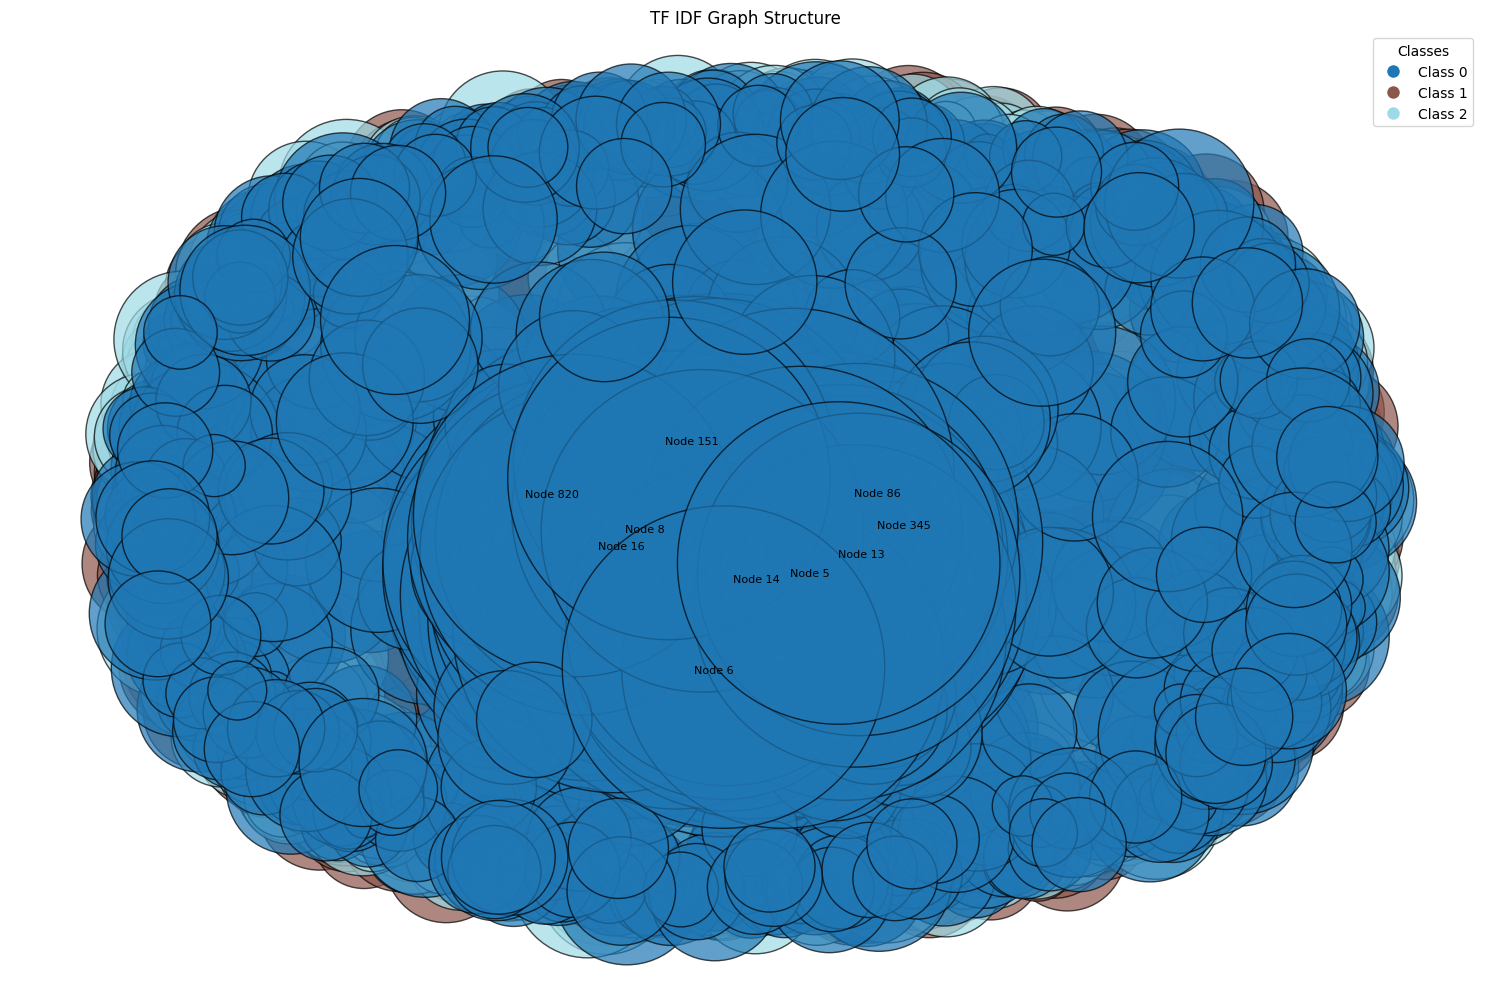


Visualizing graph metrics...


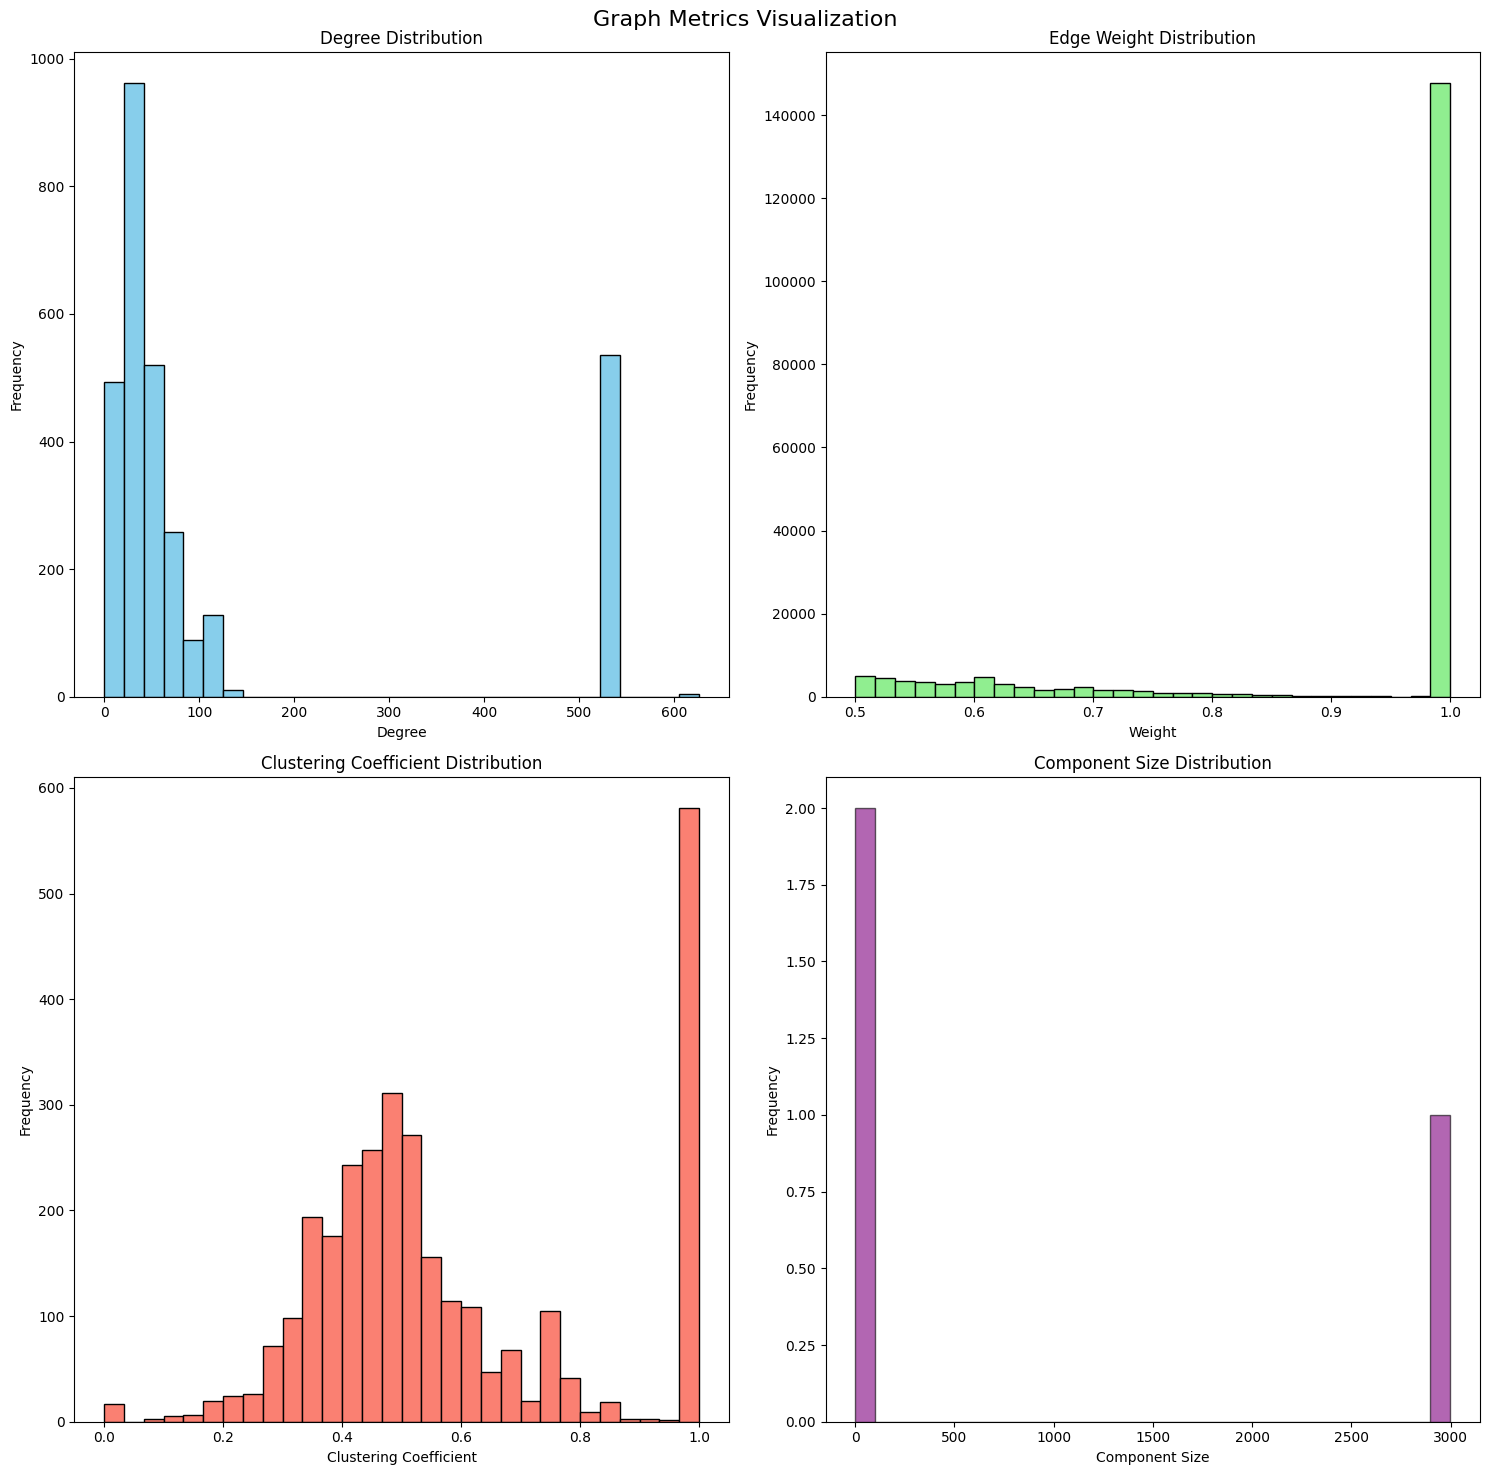


Graph Metrics Summary:
Number of nodes: 3000
Number of edges: 197482
Average degree: 131.65
Average clustering coefficient: 0.581
Number of connected components: 3
Largest component size: 2998
Graph density: 0.044

Visualizing similarity matrix...


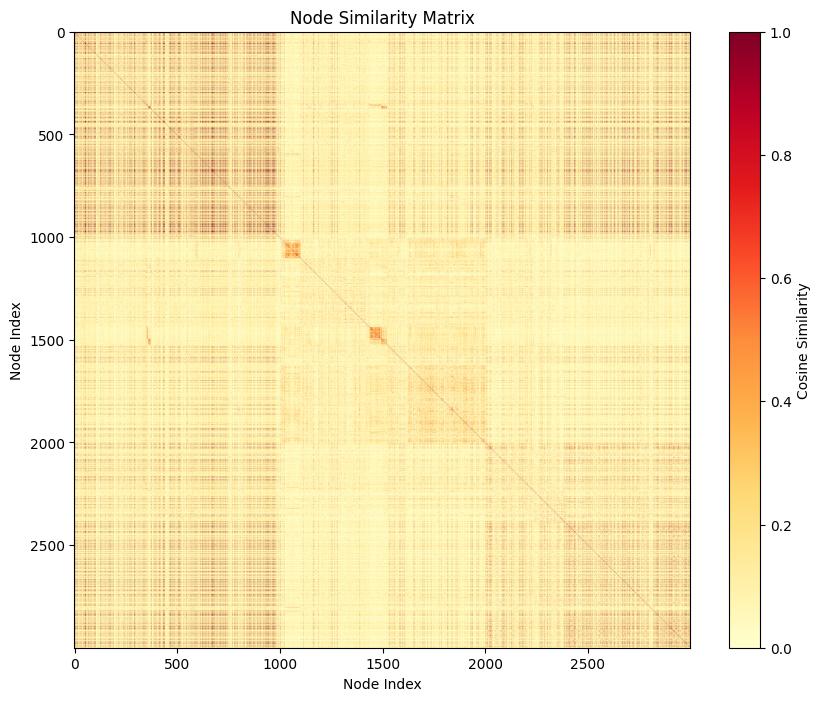


Training GCN...
Epoch 10/100, Train Loss: 0.8241, Train Acc: 0.6692, Val Loss: 0.8620, Val Acc: 0.6233
Epoch 20/100, Train Loss: 0.7257, Train Acc: 0.6817, Val Loss: 0.8204, Val Acc: 0.6367
Epoch 30/100, Train Loss: 0.6702, Train Acc: 0.7142, Val Loss: 0.7772, Val Acc: 0.6667
Epoch 40/100, Train Loss: 0.6209, Train Acc: 0.7342, Val Loss: 0.7275, Val Acc: 0.6833
Epoch 50/100, Train Loss: 0.5679, Train Acc: 0.7662, Val Loss: 0.6762, Val Acc: 0.7167
Epoch 60/100, Train Loss: 0.5142, Train Acc: 0.7871, Val Loss: 0.6323, Val Acc: 0.7267
Epoch 70/100, Train Loss: 0.4660, Train Acc: 0.8421, Val Loss: 0.5930, Val Acc: 0.7567
Epoch 80/100, Train Loss: 0.4253, Train Acc: 0.8679, Val Loss: 0.5622, Val Acc: 0.7900
Epoch 90/100, Train Loss: 0.3941, Train Acc: 0.8708, Val Loss: 0.5424, Val Acc: 0.8000
Epoch 100/100, Train Loss: 0.3698, Train Acc: 0.8867, Val Loss: 0.5280, Val Acc: 0.8100


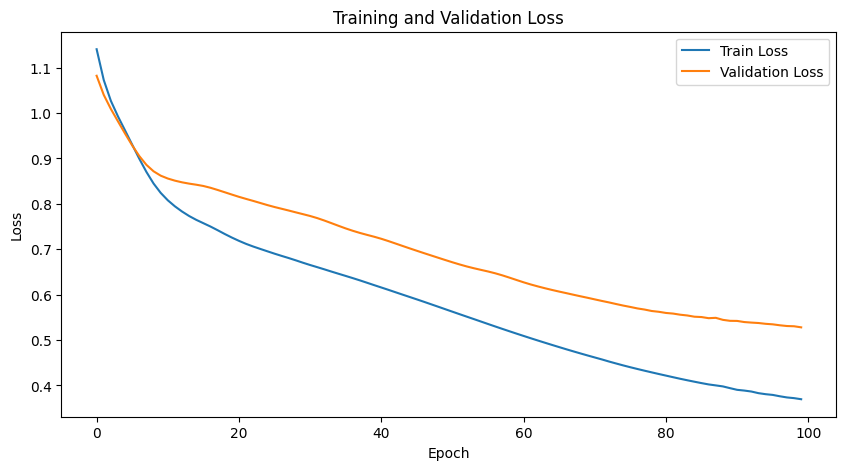

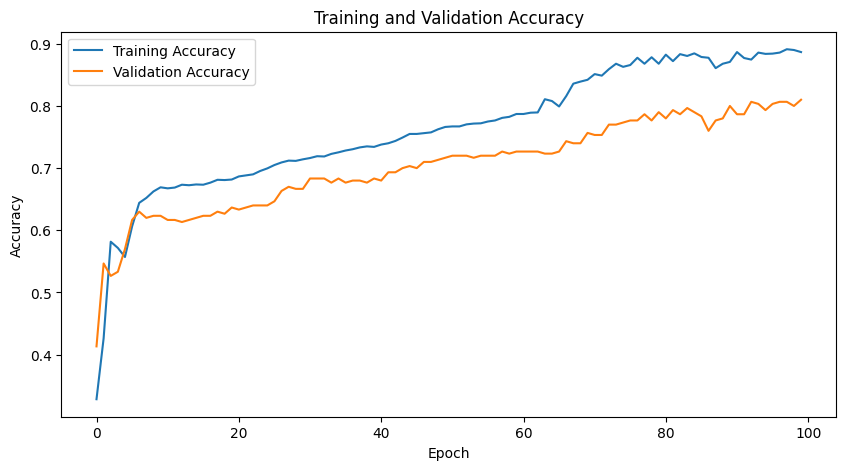


Evaluasi Testing:
Accuracy : 0.8433
Precision: 0.8433
Recall   : 0.8433
F1-Score : 0.8432


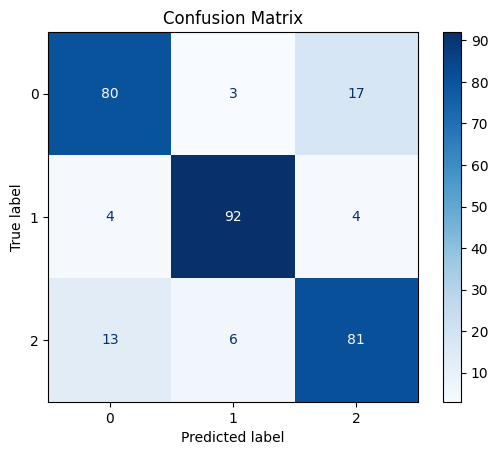


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.91      0.92      0.92       100
           2       0.79      0.81      0.80       100

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300


Training GAT...
Epoch 10/100, Train Loss: 0.7508, Train Acc: 0.6787, Val Loss: 0.8256, Val Acc: 0.6500
Epoch 20/100, Train Loss: 0.6712, Train Acc: 0.7129, Val Loss: 0.7592, Val Acc: 0.6733
Epoch 30/100, Train Loss: 0.5909, Train Acc: 0.7533, Val Loss: 0.6777, Val Acc: 0.7267
Epoch 40/100, Train Loss: 0.4896, Train Acc: 0.7946, Val Loss: 0.6034, Val Acc: 0.7733
Epoch 50/100, Train Loss: 0.4061, Train Acc: 0.8279, Val Loss: 0.5118, Val Acc: 0.8167
Epoch 60/100, Train Loss: 0.3075, Train Acc: 0.8954, Val Loss: 0.4403, Val Acc: 0.8700
Epoch 70/100, Train Loss: 0.2023, Train Acc: 0.9304, Val L

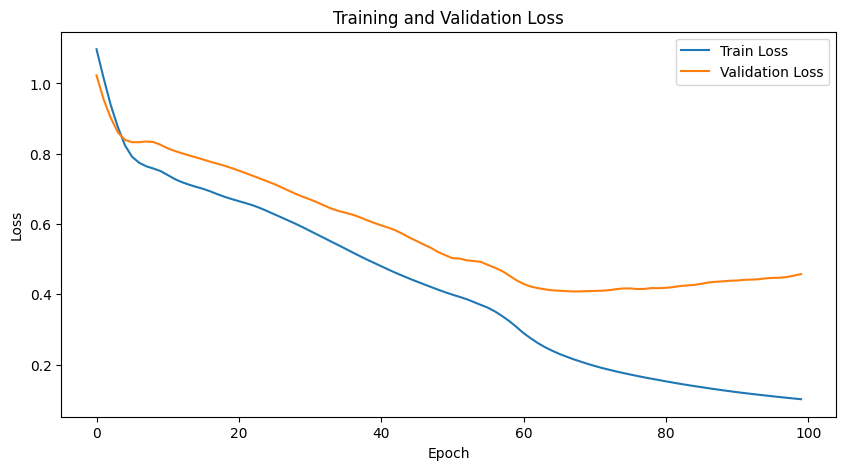

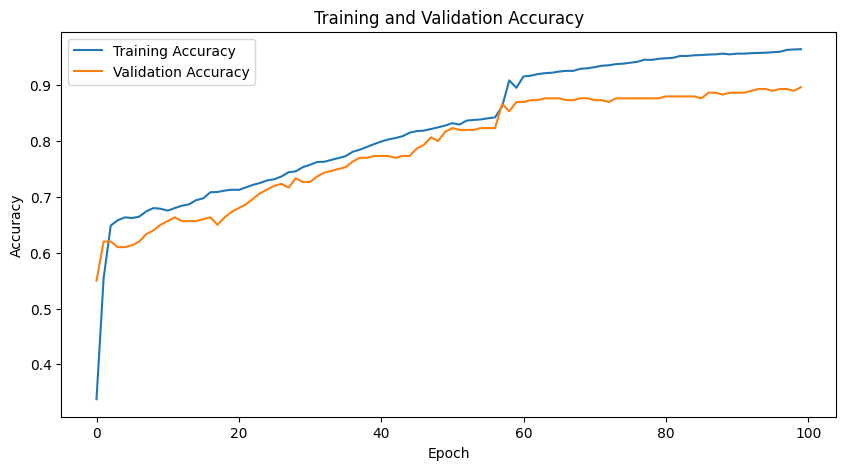


Evaluasi Testing:
Accuracy : 0.8833
Precision: 0.8844
Recall   : 0.8833
F1-Score : 0.8838


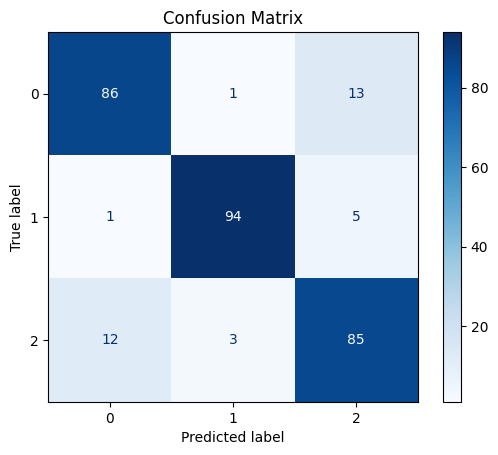


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       100
           1       0.96      0.94      0.95       100
           2       0.83      0.85      0.84       100

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300


Processing dataset: Gempa
Dataset /content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/gempa_id_cleaned.csv berhasil dimuat!
Memproses teks...
Menghitung TF-IDF...

Distribusi kelas:


Class Label  Count
0     eyewitness   1000
1       dontknow   1000
2  noneyewitness   1000


Processing TF-IDF embedding...
Generating Visualizations Graph...
Visualizing graph structure...


<ipython-input-9-bc50ba22831f>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_labels)))


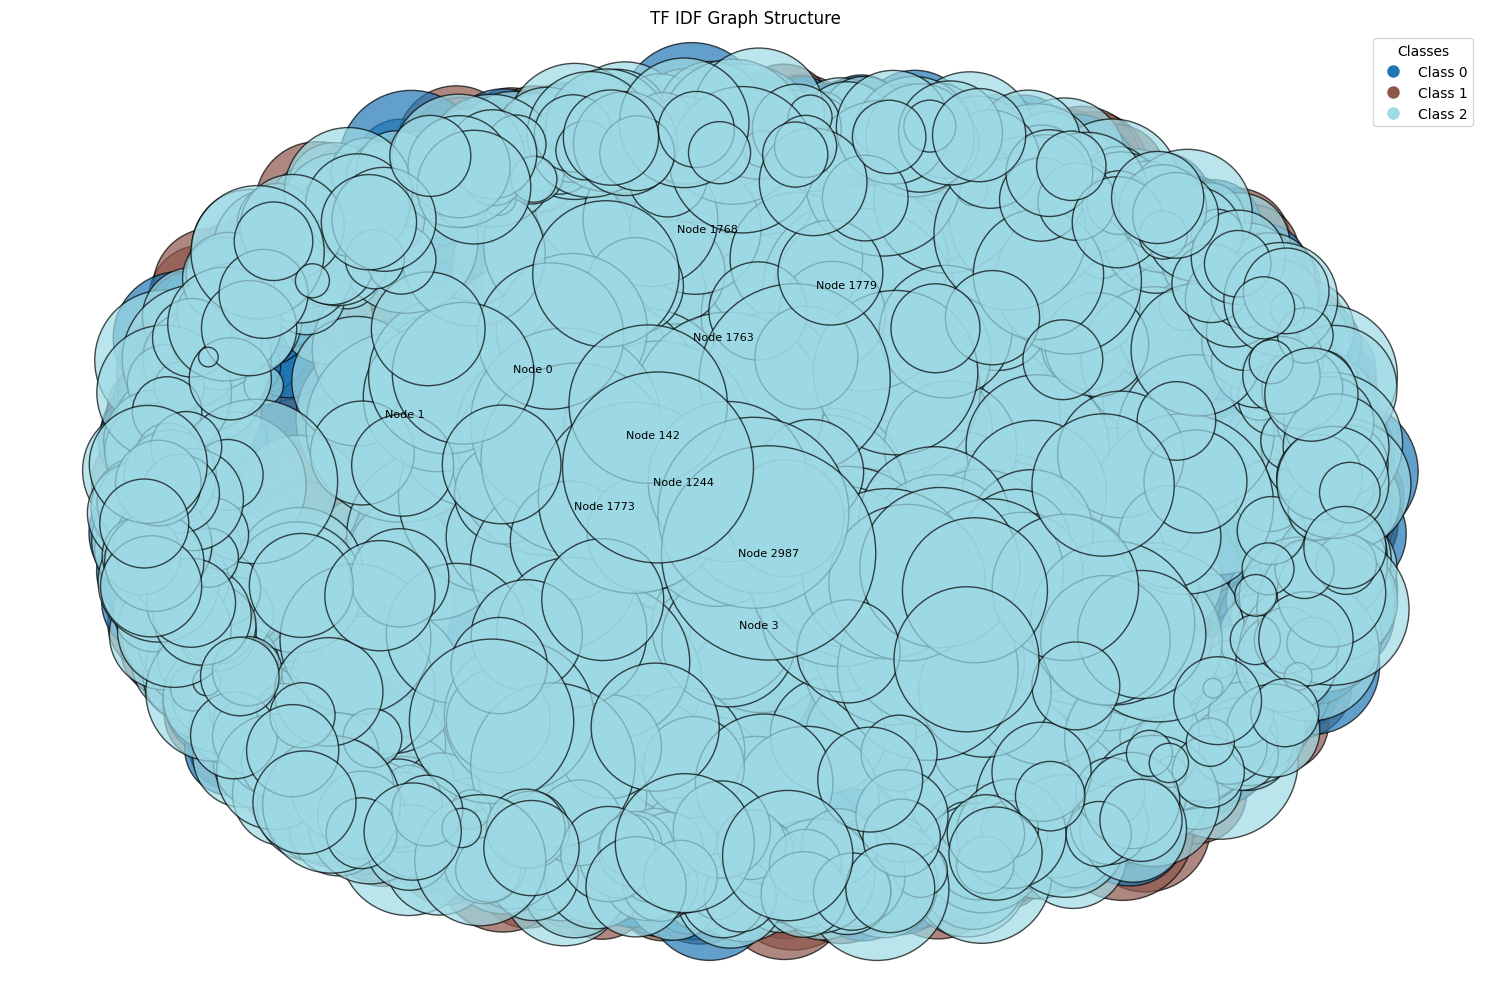


Visualizing graph metrics...


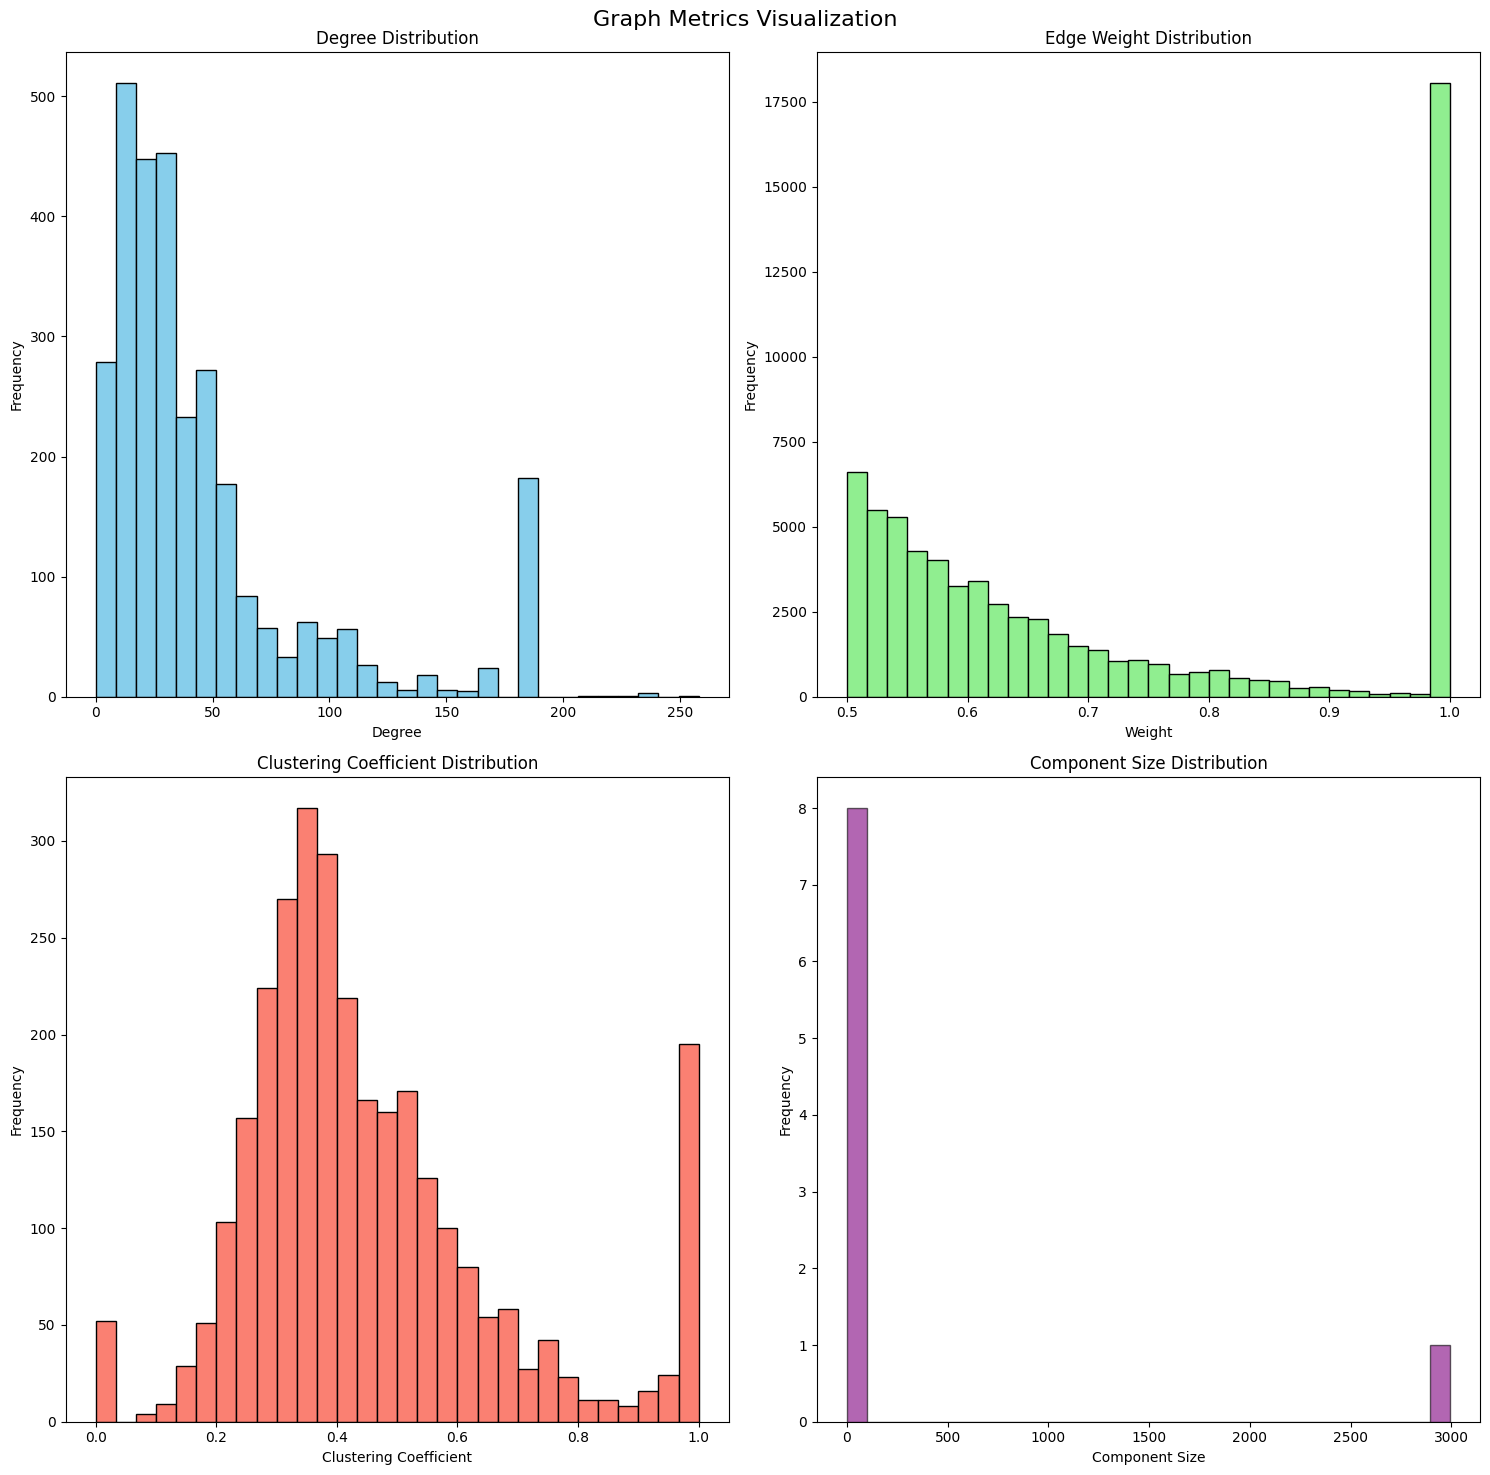


Graph Metrics Summary:
Number of nodes: 3000
Number of edges: 70528
Average degree: 47.02
Average clustering coefficient: 0.452
Number of connected components: 9
Largest component size: 2992
Graph density: 0.016

Visualizing similarity matrix...


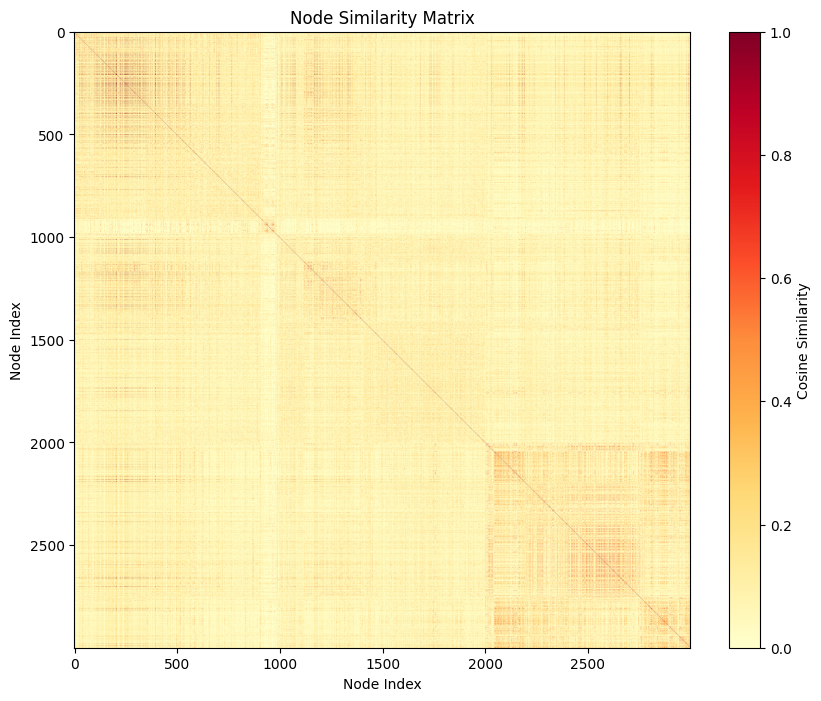


Training GCN...
Epoch 10/100, Train Loss: 0.7358, Train Acc: 0.6837, Val Loss: 0.7894, Val Acc: 0.6500
Epoch 20/100, Train Loss: 0.6571, Train Acc: 0.7258, Val Loss: 0.7493, Val Acc: 0.6733
Epoch 30/100, Train Loss: 0.6028, Train Acc: 0.7583, Val Loss: 0.6779, Val Acc: 0.6900
Epoch 40/100, Train Loss: 0.5562, Train Acc: 0.7729, Val Loss: 0.6454, Val Acc: 0.7067
Epoch 50/100, Train Loss: 0.5110, Train Acc: 0.8079, Val Loss: 0.6118, Val Acc: 0.7433
Epoch 60/100, Train Loss: 0.4669, Train Acc: 0.8233, Val Loss: 0.5676, Val Acc: 0.7733
Epoch 70/100, Train Loss: 0.4248, Train Acc: 0.8408, Val Loss: 0.5286, Val Acc: 0.7967
Epoch 80/100, Train Loss: 0.3879, Train Acc: 0.8625, Val Loss: 0.4968, Val Acc: 0.7967
Epoch 90/100, Train Loss: 0.3566, Train Acc: 0.8704, Val Loss: 0.4725, Val Acc: 0.8100
Epoch 100/100, Train Loss: 0.3298, Train Acc: 0.8812, Val Loss: 0.4531, Val Acc: 0.8133


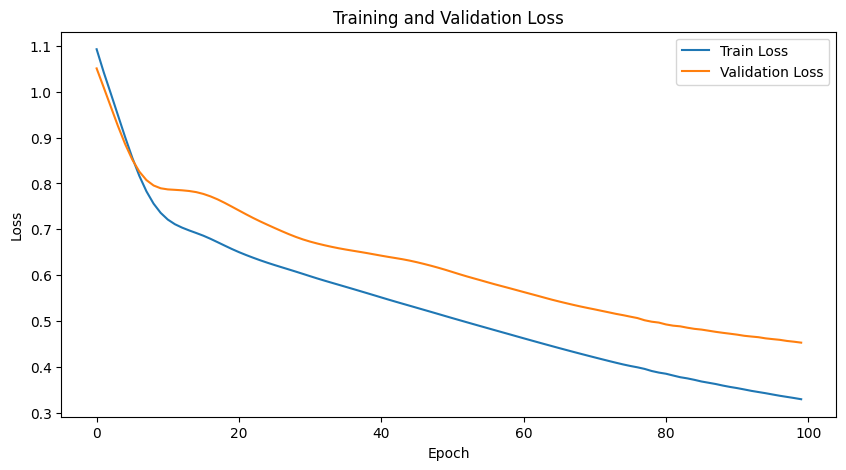

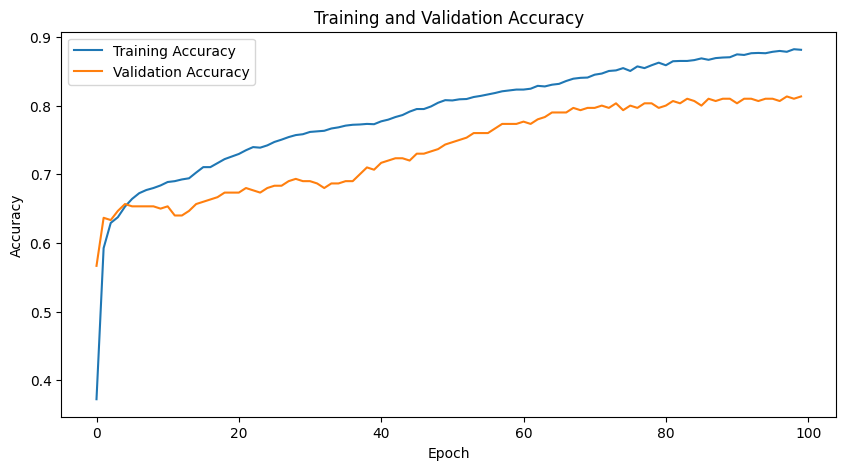


Evaluasi Testing:
Accuracy : 0.8567
Precision: 0.8622
Recall   : 0.8567
F1-Score : 0.8569


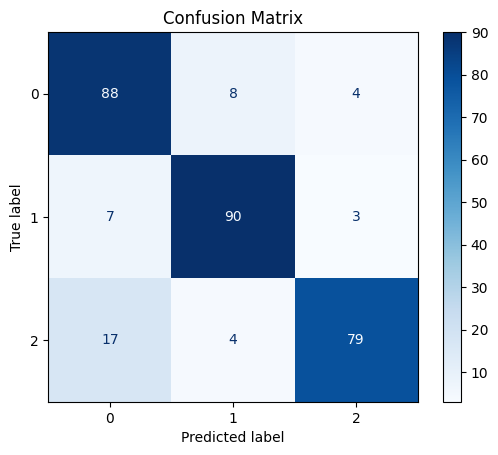


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.88      0.90      0.89       100
           2       0.92      0.79      0.85       100

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300


Training GAT...
Epoch 10/100, Train Loss: 0.6929, Train Acc: 0.7083, Val Loss: 0.7756, Val Acc: 0.6633
Epoch 20/100, Train Loss: 0.5659, Train Acc: 0.7658, Val Loss: 0.6517, Val Acc: 0.7333
Epoch 30/100, Train Loss: 0.4691, Train Acc: 0.8125, Val Loss: 0.5465, Val Acc: 0.7700
Epoch 40/100, Train Loss: 0.3859, Train Acc: 0.8408, Val Loss: 0.4959, Val Acc: 0.7933
Epoch 50/100, Train Loss: 0.3020, Train Acc: 0.8904, Val Loss: 0.4621, Val Acc: 0.8300
Epoch 60/100, Train Loss: 0.2369, Train Acc: 0.9158, Val Loss: 0.4371, Val Acc: 0.8367
Epoch 70/100, Train Loss: 0.1788, Train Acc: 0.9363, Val L

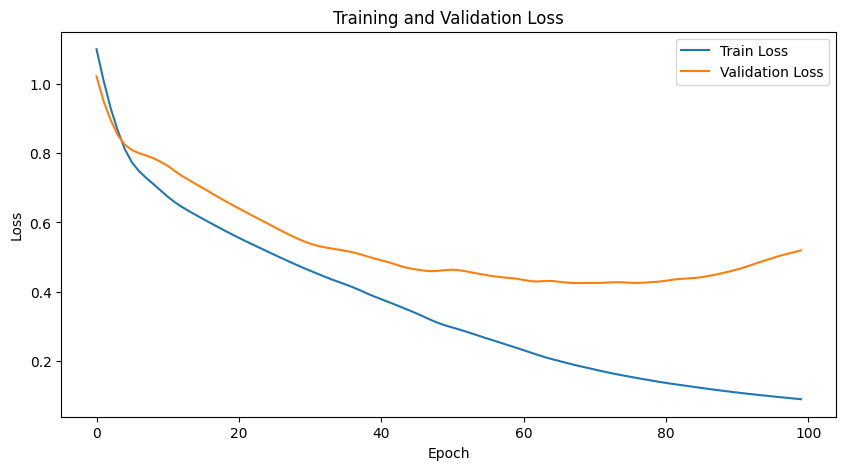

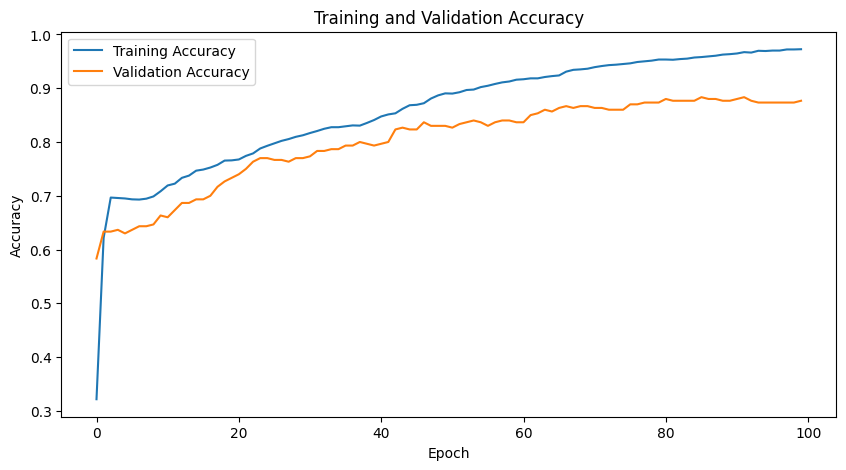


Evaluasi Testing:
Accuracy : 0.8967
Precision: 0.8979
Recall   : 0.8967
F1-Score : 0.8971


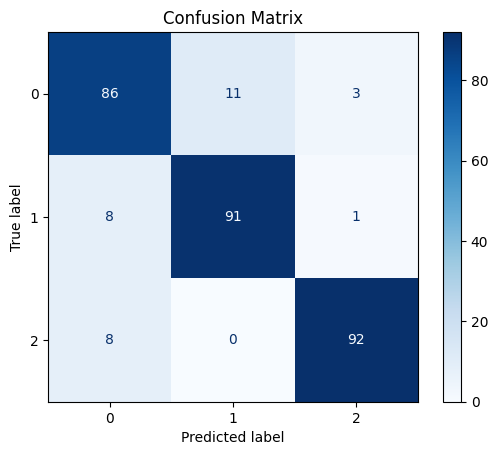


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       100
           1       0.89      0.91      0.90       100
           2       0.96      0.92      0.94       100

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Processing dataset: Fire Forest
Dataset /content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/kebakaran_id_cleaned_V1.csv berhasil dimuat!
Memproses teks...
Menghitung TF-IDF...

Distribusi kelas:


Class Label  Count
0     eyewitness   1000
1  noneyewitness   1000
2       dontknow   1000


Processing TF-IDF embedding...
Generating Visualizations Graph...
Visualizing graph structure...


<ipython-input-9-bc50ba22831f>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_labels)))


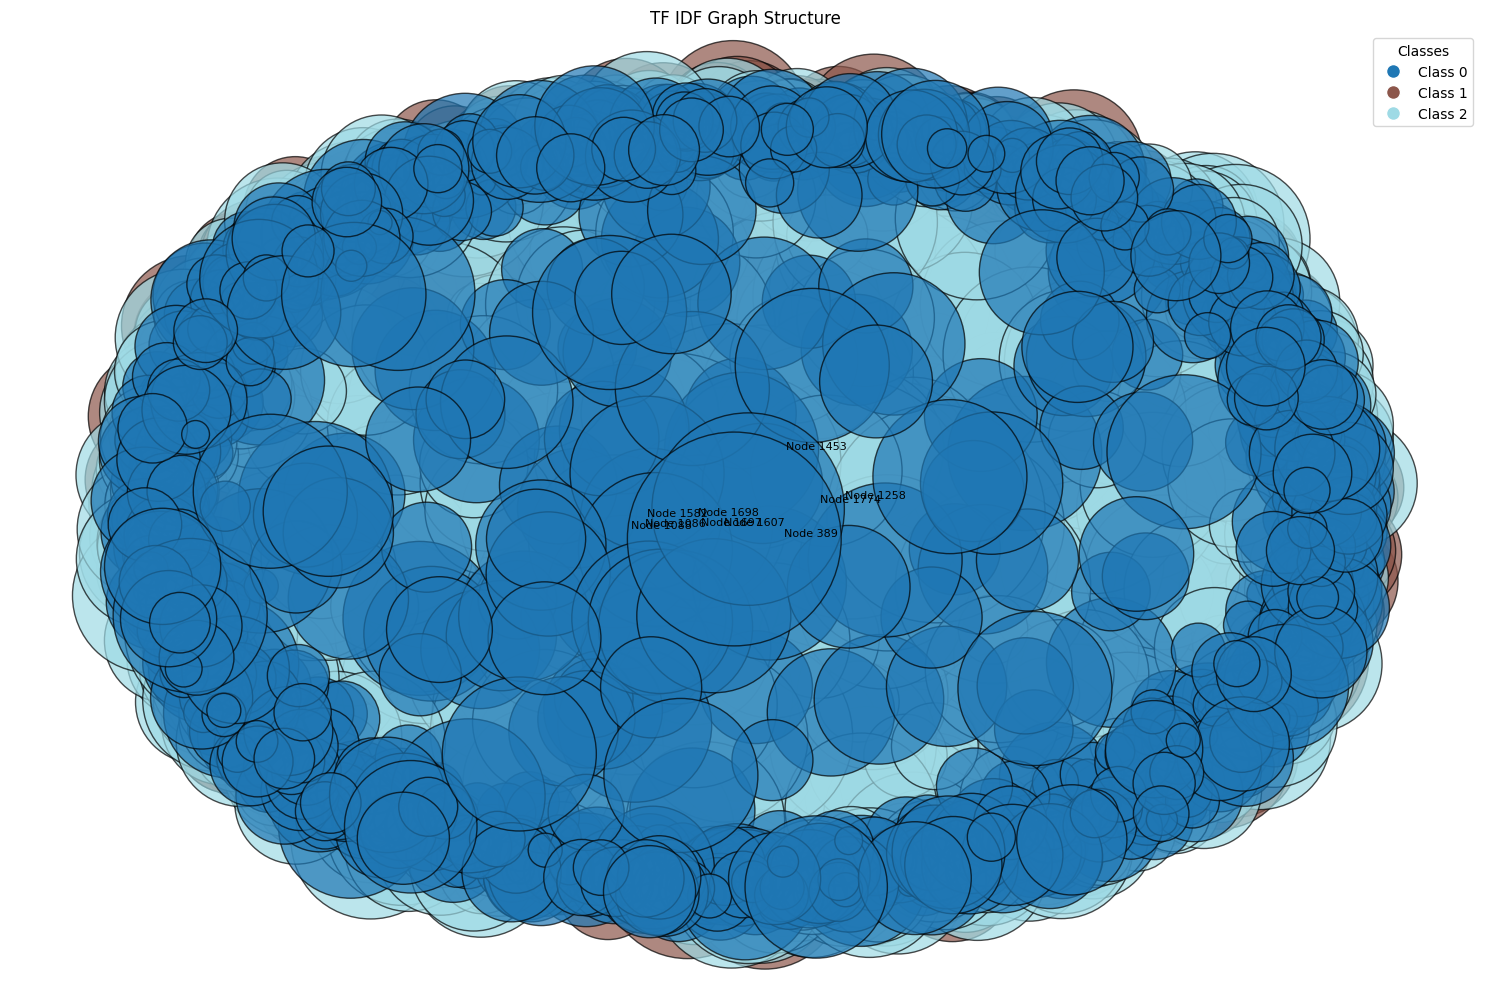


Visualizing graph metrics...


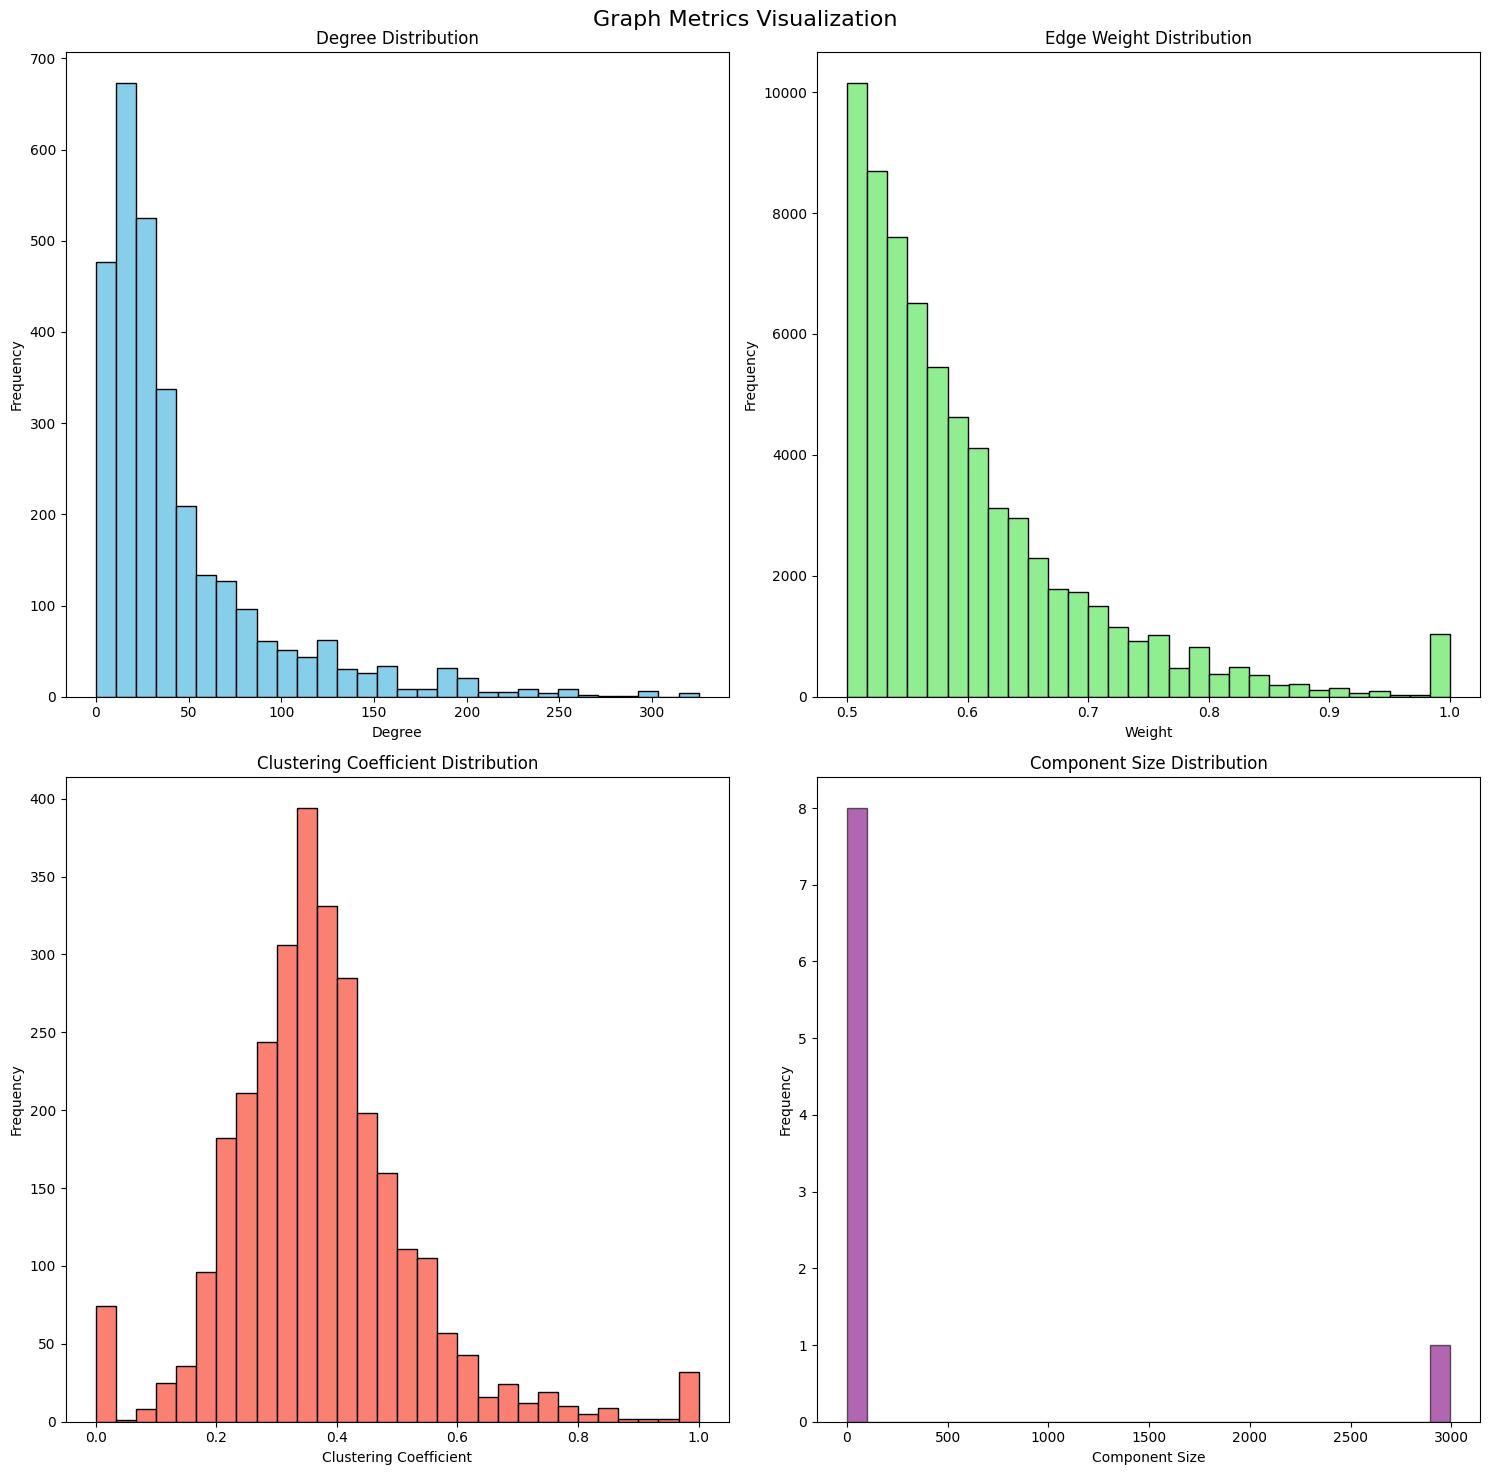


Graph Metrics Summary:
Number of nodes: 3000
Number of edges: 68082
Average degree: 45.39
Average clustering coefficient: 0.371
Number of connected components: 9
Largest component size: 2992
Graph density: 0.015

Visualizing similarity matrix...


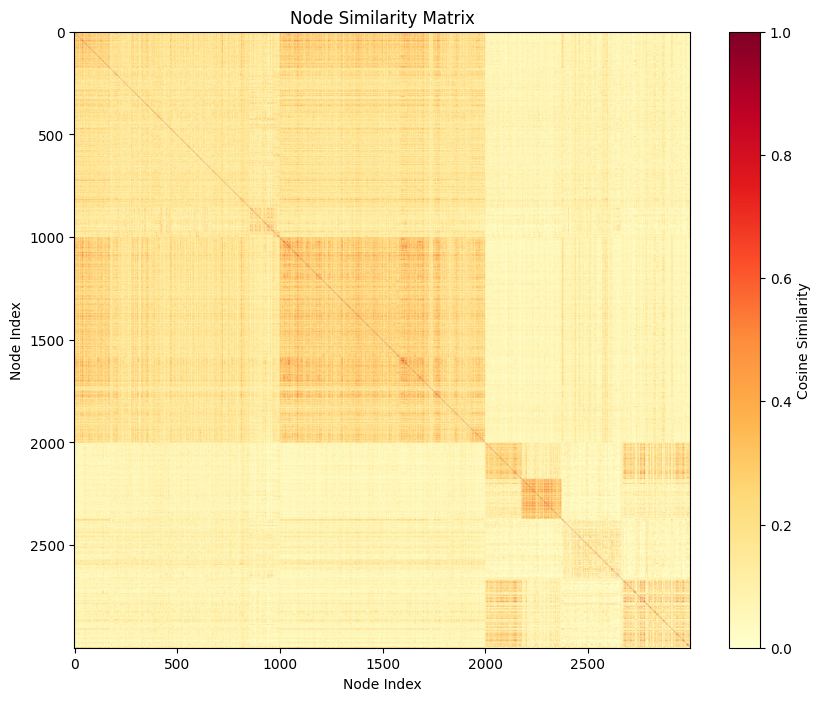


Training GCN...
Epoch 10/100, Train Loss: 0.7054, Train Acc: 0.7092, Val Loss: 0.6686, Val Acc: 0.7233
Epoch 20/100, Train Loss: 0.5886, Train Acc: 0.7458, Val Loss: 0.5649, Val Acc: 0.7600
Epoch 30/100, Train Loss: 0.5059, Train Acc: 0.8029, Val Loss: 0.5402, Val Acc: 0.7700
Epoch 40/100, Train Loss: 0.4442, Train Acc: 0.8354, Val Loss: 0.4889, Val Acc: 0.7933
Epoch 50/100, Train Loss: 0.3939, Train Acc: 0.8621, Val Loss: 0.4438, Val Acc: 0.8167
Epoch 60/100, Train Loss: 0.3522, Train Acc: 0.8812, Val Loss: 0.3996, Val Acc: 0.8333
Epoch 70/100, Train Loss: 0.3169, Train Acc: 0.8979, Val Loss: 0.3684, Val Acc: 0.8567
Epoch 80/100, Train Loss: 0.2872, Train Acc: 0.9062, Val Loss: 0.3451, Val Acc: 0.8733
Epoch 90/100, Train Loss: 0.2632, Train Acc: 0.9113, Val Loss: 0.3335, Val Acc: 0.8833
Epoch 100/100, Train Loss: 0.2421, Train Acc: 0.9183, Val Loss: 0.3257, Val Acc: 0.8833


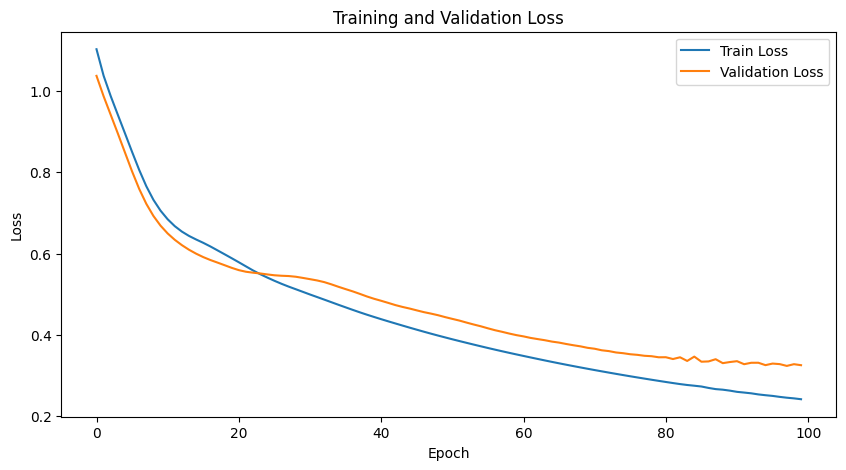

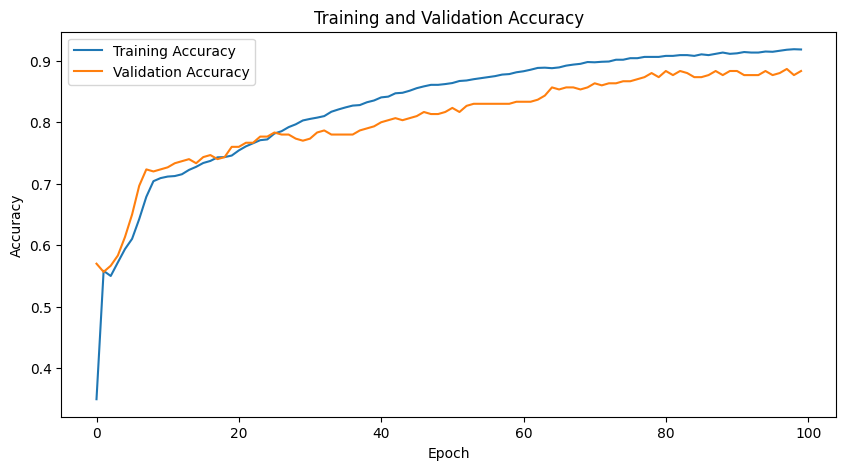


Evaluasi Testing:
Accuracy : 0.8833
Precision: 0.8834
Recall   : 0.8833
F1-Score : 0.8823


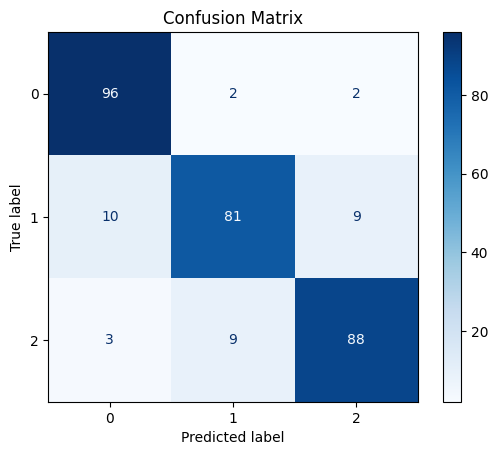


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       100
           1       0.88      0.81      0.84       100
           2       0.89      0.88      0.88       100

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300


Training GAT...
Epoch 10/100, Train Loss: 0.6260, Train Acc: 0.7575, Val Loss: 0.5630, Val Acc: 0.7567
Epoch 20/100, Train Loss: 0.4235, Train Acc: 0.8421, Val Loss: 0.4440, Val Acc: 0.8167
Epoch 30/100, Train Loss: 0.2665, Train Acc: 0.9092, Val Loss: 0.2817, Val Acc: 0.9033
Epoch 40/100, Train Loss: 0.1641, Train Acc: 0.9492, Val Loss: 0.2171, Val Acc: 0.9100
Epoch 50/100, Train Loss: 0.1177, Train Acc: 0.9637, Val Loss: 0.1933, Val Acc: 0.9267
Epoch 60/100, Train Loss: 0.0882, Train Acc: 0.9725, Val Loss: 0.1927, Val Acc: 0.9400
Epoch 70/100, Train Loss: 0.0656, Train Acc: 0.9808, Val L

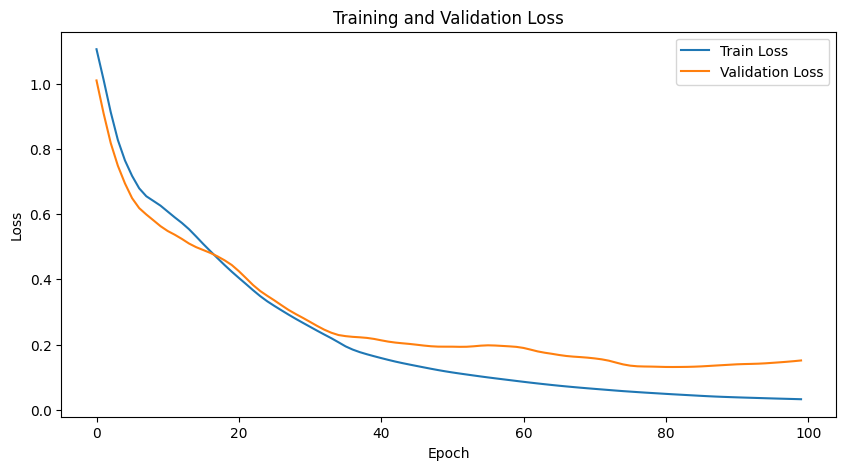

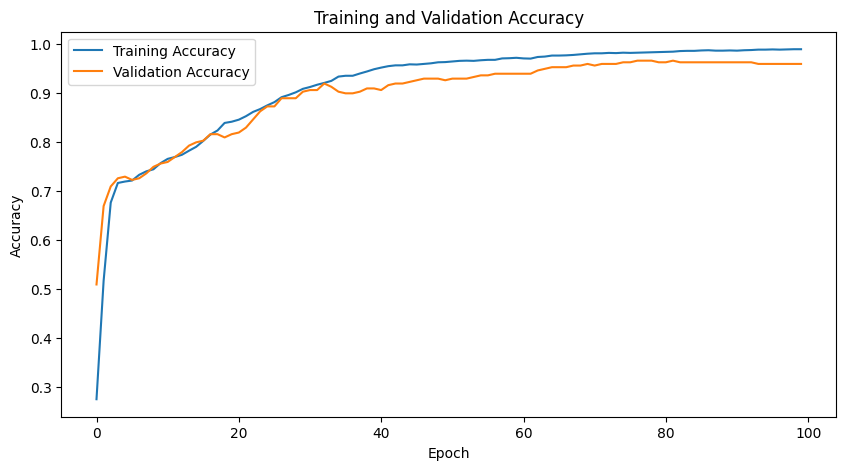


Evaluasi Testing:
Accuracy : 0.9600
Precision: 0.9603
Recall   : 0.9600
F1-Score : 0.9601


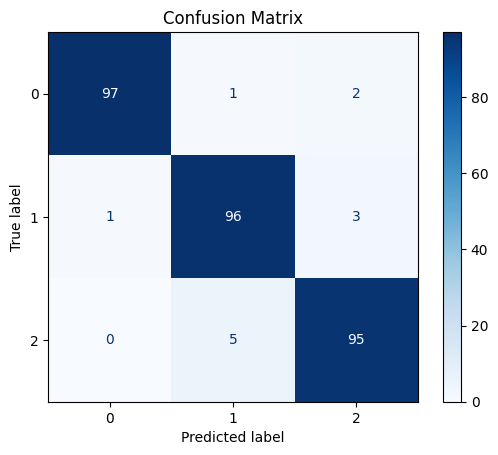


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.94      0.96      0.95       100
           2       0.95      0.95      0.95       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
# Main processing untuk TF-IDF
datasets = {
    "Banjir": "/content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/banjir_id_cleaned.csv",
    "Gempa": "/content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/gempa_id_cleaned.csv",
    "Fire Forest": "/content/drive/MyDrive/Project Graph Neural Network/Graph Neural Network - Natural Disaster Clasification/Dataset/IND/kebakaran_id_cleaned_V1.csv",
}

tfidf_vectorizer = TfidfVectorizer(max_features=100)

results = {}

for disaster_type, file_path in datasets.items():
    print(f"\nProcessing dataset: {disaster_type}")
    data = load_and_process_dataset(file_path, tfidf_vectorizer)
    if data is None:
        continue

    print("\nProcessing TF-IDF embedding...")
    graph = build_graph(data, similarity_threshold=0.5, embedding_col='tfidf_embedding')
    pyg_data = convert_to_pyg_data(graph)

    print("Generating Visualizations Graph...")
    visualize_complete_graph(data, graph)

    input_dim = pyg_data.x.shape[1]
    hidden_dim = 64
    output_dim = len(set(pyg_data.y.numpy()))

    train_idx, test_idx = train_test_split(range(pyg_data.num_nodes), test_size=0.2, stratify=pyg_data.y.numpy(), random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=pyg_data.y.numpy()[test_idx], random_state=42)

    train_mask = torch.tensor([i in train_idx for i in range(pyg_data.num_nodes)], dtype=torch.bool)
    val_mask = torch.tensor([i in val_idx for i in range(pyg_data.num_nodes)], dtype=torch.bool)
    test_mask = torch.tensor([i in test_idx for i in range(pyg_data.num_nodes)], dtype=torch.bool)

    pyg_data.train_mask = train_mask
    pyg_data.val_mask = val_mask
    pyg_data.test_mask = test_mask

    print("\nTraining GCN...")
    model_gcn = GCNModel(input_dim, hidden_dim, output_dim)
    optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.01)
    gcn_results = train_and_evaluate(model_gcn, optimizer_gcn, pyg_data)

    print("\nTraining GAT...")
    model_gat = GATModel(input_dim, hidden_dim, output_dim)
    optimizer_gat = torch.optim.Adam(model_gat.parameters(), lr=0.01)
    gat_results = train_and_evaluate(model_gat, optimizer_gat, pyg_data)

    results[f"{disaster_type}_TF-IDF"] = {
        "GCN": gcn_results,
        "GAT": gat_results
    }